# Dog Breed Classification

Dog breed classification is the process of using machine learning algorithms to identify and distinguish between different breeds of dogs based on their physical characteristics and features.

In [5]:
# Installing Required packages
!pip install smdebug

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
# Importing required Libraries
import sagemaker
import boto3
import os

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerConfig, 
    CollectionConfig, 
    FrameworkProfile,
)

## Dataset

The Dog breed dataset is a collection of images of dogs belonging to **133** different breeds. The Dataset has **6680** images of dogs of different breeds in train split, **836** images in test split and **835** images in valid split. 

Size of Images - **172800**  
Shape of the Image - **(240, 240, 3)**

![Alaskan_malamute](dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00302.jpg)

The Dataset has 133 class distribution. Here is the top 10 breeds with many images of 

**Alaskan_malamute**: 77   
**Border_collie**: 74    
**Basset_hound**: 73  
**Dalmatian**: 71   
**Bullmastiff**: 69  
**Bull_terrier**: 69   
**Basenji**: 69  
**Cavalier_king_charles_spaniel**: 67  
**Irish_terrier**: 66  
**Australian_cattle_dog**: 66

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [5]:
# Uploading the dataset to S3 Bucket
s3_path_to_data = sagemaker.Session().upload_data(bucket='sagemaker-us-east-1-497446673054', 
                                                  path='dogImages', 
                                                  key_prefix='ProjectData')

In [ ]:
import imageio
import matplotlib.pyplot as plt

%matplotlib inline

pic = imageio.imread('dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00302.jpg')
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [ ]:
print('Shape of the image : {}'.format(pic.shape))

In [ ]:
import re

count = 0
dogs = {}
pattern = r'[\d.]'

for breed in os.listdir('dogImages/train'):
    breed_count = len(os.listdir(os.path.join('dogImages/train', breed)))
    dogs[re.sub(pattern, '', breed)] = breed_count

sorted_dict = dict(sorted(dogs.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
from sagemaker.tensorflow import TensorFlow

role = sagemaker.get_execution_role()
instance_type = "ml.m5.large"
output_bucket = 'sagemaker-us-east-1-497446673054'
sagemaker_session = sagemaker.Session()
s3_path_to_data = 's3://sagemaker-us-east-1-497446673054/ProjectData'

output_prefix = "ImageClassificationModel"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [8]:
# Hyperparameters Ranges
hyperparameter_ranges =  {
    "learning_rate": ContinuousParameter(0.0001, 0.1, scaling_type="Logarithmic"),
    "units": CategoricalParameter([256, 512, 1024]),
    "epochs": IntegerParameter(1, 6)
}

In [9]:
objective_metric_name = "val_accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}]
training_metric_definitions = [
    {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "train_accuracy", "Regex": "- accuracy: ([0-9\\.]+)"},
    {"Name": "train_loss", "Regex": "- loss: ([0-9\\.]+)"},
]

In [10]:
estimator = TensorFlow(
    role=role,
    entry_point="hpo.py",
    instance_count=1,
    instance_type=instance_type,
    output_path=s3_output_location,
    framework_version="2.1.0",
    py_version="py3",
    metric_definitions=training_metric_definitions
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [11]:
TRAIN_DATA_DIR = os.path.join(s3_path_to_data, 'train')
VALIDATION_DATA_DIR = os.path.join(s3_path_to_data, 'valid')

In [12]:
train_data = sagemaker.inputs.TrainingInput(
    TRAIN_DATA_DIR,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.inputs.TrainingInput(
    VALIDATION_DATA_DIR,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

In [27]:
# Fitting HP Tuner
tuner.fit({'train': train_data, 'validation': validation_data})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
best_training = tuner.best_training_job()
print('Best Training Job name: {}'.format(best_training))

In [29]:
# Getting the best estimators and the best HPs
best_estimator = tuner.best_estimator({"TrainingJobName": best_training})

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-09 18:17:17 Starting - Preparing the instances for training
2023-03-09 18:17:17 Downloading - Downloading input data
2023-03-09 18:17:17 Training - Training image download completed. Training in progress.
2023-03-09 18:17:17 Uploading - Uploading generated training model
2023-03-09 18:17:17 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"val_accuracy"',
 'epochs': '5',
 'learning_rate': '0.00012174621734259434',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"TensorFlow"',
 'sagemaker_estimator_module': '"sagemaker.tensorflow.estimator"',
 'sagemaker_job_name': '"tensorflow-training-2023-03-09-17-25-22-870"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-09-17-25-22-870/source/sourcedir.tar.gz"',
 'units': '"512"',
 'model_dir': '"s3://sagemaker-us-east-1-497446673054/ImageClassificationModel/output/tensorflow-training-2023-03-09-17-25-22-870/model"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {
    "learning_rate": 0.00012174621734259434,
    "units": 512,
    "epochs": 5,
    }

rules = [
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))

collection = [
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "3",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "3",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "3",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="loss", 
        parameters={
            "include_regex": "losses",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    ),
]

hook = DebuggerHookConfig(hook_parameters={"train.save_interval": "3", "eval.save_interval": "1"}, collection_configs=collection)

In [16]:
# TODO: Create and fit an estimator

estimator = TensorFlow(
    role=role,
    entry_point="train_model.py",
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    hyperparameters=hyperparameters,
    framework_version="2.1.0",
    py_version="py3",
    rules=rules,
    debugger_hook_config=hook,
    profiler_config=profiler,
)

estimator.fit({'train': train_data, 'validation': validation_data}, wait=True)

2023-03-11 18:34:41 Starting - Starting the training job...
2023-03-11 18:35:05 Starting - Preparing the instances for trainingOverfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-11 18:35:58 Downloading - Downloading input data.....2023-03-11 18:36:48,404 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2023-03-11 18:36:48,412 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-11 18:36:48,596 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-11 18:36:48,613 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-11 18:36:48,629 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-11 18:36:48,639 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_pa

In [17]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-11 18:59:54.690 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/debug-output
[2023-03-11 18:59:55.163 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:23 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 44819 more expected)', IncompleteRead(0 bytes read, 44819 more expected)) while reading s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/debug-output/index/000000000/000000000072_worker_0.json . Will retry now


In [18]:
len(trial.tensor("loss").steps(mode=ModeKeys.TRAIN))

[2023-03-11 19:01:30.406 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:23 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-11 19:01:31.429 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:23 INFO trial.py:210] Loaded all steps


8

In [19]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

In [20]:
! pip install matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    host.set_xlabel("Steps (TRAIN)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    plt.savefig('Debugger_result.png')

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


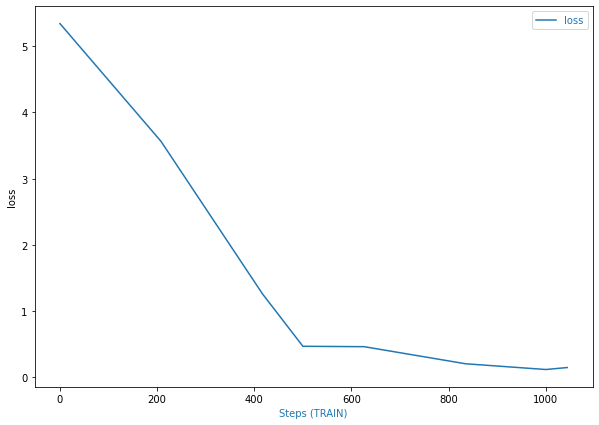

<Figure size 432x288 with 0 Axes>

In [21]:
# TODO: Plot a debugging output.
plot_tensor(trial, "loss")

In [22]:
! pip install jinja2==3.0.3 --force-reinstall 
! pip install bokeh

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = estimator.latest_training_job.name
training_job = TrainingJob(training_job_name)
training_job.wait_for_sys_profiling_data_to_be_available()

  Using cached Jinja2-3.0.3-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-497446673054/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/profiler-output


Profiler data from system is available


In [23]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/rule-output


In [24]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-497446673054/tens

In [25]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [26]:
from sagemaker.tensorflow import TensorFlowModel

model_path = 's3://sagemaker-us-east-1-497446673054/tensorflow-training-2023-03-11-18-34-40-986/output/model.tar.gz'
entry_point = 'predict.py'
model = TensorFlowModel(
    model_data=model_path, 
    role=role, 
    entry_point=entry_point,
    framework_version="2.1.0",
)

In [27]:
# TODO: Deploy your model to an endpoint

predictor=model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


------!

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def read_and_transform_image(folder_path, img_size):
    # Define image data generator with rescaling
    data_generator = ImageDataGenerator(rescale=1./255)
    
    test_data = data_generator.flow_from_directory(
        folder_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

    return test_data

In [29]:
# TODO: Run an prediction on the endpoint
import json 

image = read_and_transform_image('dogImages/test', (224, 224))

response = predictor.predict(image[0][0])

Found 836 images belonging to 133 classes.


ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/tensorflow-inference-2023-03-11-19-12-11-392/invocations".

In [30]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()